<a href="https://colab.research.google.com/github/arkinbhagat/MSc-Project/blob/main/MSc_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

These are python library imports required for the functions used in the notebook.

In [ ]:
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import random
from datetime import datetime
from networkx.algorithms.coloring.greedy_coloring import greedy_color
from networkx.algorithms.coloring.equitable_coloring import equitable_color

# Functions

The following section defines various functions designed to work with the dataset. Implementation details are provided in the accompanying project report.

In [ ]:
def getduration(exam):
  return(exams.loc[exams['ExamID'] == exam]['Duration'].item())

def getcapacity(room):
  return(rooms.loc[rooms['Room'] == room]['Total Capacity'].item())

def getstudents(exam):
  return(list(enrolments.loc[enrolments['ExamID'] == exam, 'StudentID']))

def getstudentcount(exam):
  return(len(list(enrolments.loc[enrolments['ExamID'] == exam, 'StudentID'])))

def getusedhours(room, slot):
  return(allslots.loc[(allslots['Room'] == room) & (allslots['Slot'] == slot)]['Used Hours'].item())

def getusedcapacity(room, slot):
  return(allslots.loc[(allslots['Room'] == room) & (allslots['Slot'] == slot)]['Used Capacity'].item())  
  
def setusedhours(room, slot, num):
  x = allslots.index[(allslots.Room==room) & (allslots.Slot==slot)].item()
  allslots.loc[x, "Used Hours"] = num

def setusedcapacity(room, slot, num):
  x = allslots.index[(allslots.Room==room) & (allslots.Slot==slot)].item()
  allslots.loc[x, "Used Capacity"] = num

def costfunction(df):
 return(df[(df["Total Capacity"]*df["Scheduled Exams"]<df["Used Capacity"]) | (df["Total Hours"]<df["Used Hours"])]["Slot"].count()) 

def check_conflict(k, idx):
  if((network.has_edge(allslots.loc[idx, "Exam 1"], k)) | (network.has_edge(allslots.loc[idx, "Exam 2"], k)) | (network.has_edge(allslots.loc[idx, "Exam 3"], k))):
        return(True)   

def remove_exam(k, idx):
    allslots.loc[idx, "Used Capacity"] -= getstudentcount(k)
    allslots.loc[idx, "Used Hours"] -= getduration(k)
    allslots.loc[idx, "Scheduled Exams"] -= 1    

    if(allslots.loc[idx, "Exam 1"] == k):
      allslots.loc[idx, "Exam 1"] = None
    elif(allslots.loc[idx, "Exam 2"] == k):
      allslots.loc[idx, "Exam 2"] = None
    elif(allslots.loc[idx, "Exam 3"] == k):
      allslots.loc[idx, "Exam 3"] = None  

def add_exam(k, idx):
    allslots.loc[idx, "Used Capacity"] += getstudentcount(k)
    allslots.loc[idx, "Used Hours"] += getduration(k)
    allslots.loc[idx, "Scheduled Exams"] += 1 

    if(allslots.loc[idx, "Exam 1"] == None):
      allslots.loc[idx, "Exam 1"] = k
    elif(allslots.loc[idx, "Exam 2"] == None):
      allslots.loc[idx, "Exam 2"] = k
    elif(allslots.loc[idx, "Exam 3"] == None):
      allslots.loc[idx, "Exam 3"] = k    
      

def swap_exams(exam1, exam2):
  index_e1 = allslots.loc[(allslots['Exam 1'] == exam1) | (allslots['Exam 2'] == exam1) | (allslots['Exam 3'] == exam1)].index.item()
  index_e2 = allslots.loc[(allslots['Exam 1'] == exam2) | (allslots['Exam 2'] == exam2) | (allslots['Exam 3'] == exam2)].index.item() 

  if(not(check_conflict(exam1, index_e2) and check_conflict(exam2, index_e1))):
    remove_exam(exam1, index_e1)
    add_exam(exam2, index_e1)  

    remove_exam(exam2, index_e2)
    add_exam(exam1, index_e2)    

# Importing of Exam Data

Imports the exam data from the .csv files.

In [ ]:
stud_cols = ["StudentID", "CourseID"]
students = pd.read_csv("students.csv", names=stud_cols)
students['StudentID'] = students['StudentID'].astype(str)
courseid = students["CourseID"].unique()
studentid = students["StudentID"].unique()

enrol_cols = ["StudentID", "ExamID"]
enrolments = pd.read_csv("enrolments.csv", names=enrol_cols)
enrolments['StudentID'] = enrolments['StudentID'].astype(str)
examid = enrolments["ExamID"].unique()
students_per_exam = dict(enrolments.groupby(["ExamID"])["ExamID"].count())

exam_cols = ["ExamID", "Duration"]
exams = pd.read_csv("exams.csv", names=exam_cols)
exams['Student Count'] = exams['ExamID'].astype(str).map(students_per_exam) 

timeslots_cols = ["Slot", "Total Hours"]
timeslots = pd.read_csv("timeslots.csv", names=timeslots_cols)
slots = timeslots["Slot"]

rooms_cols = ["Room", "Total Capacity"]
rooms = pd.read_csv("rooms.csv", names=rooms_cols)
roomid = rooms["Room"]

allslots = pd.merge(rooms, timeslots, how = 'cross')
allslots = allslots.reindex(columns=["Room", "Slot", "Total Capacity", "Total Hours"])

In [ ]:
allslots["Used Capacity"] = 0
allslots["Used Hours"] = 0
allslots["Exam 1"] = None
allslots["Exam 2"] = None
allslots["Exam 3"] = None
allslots["Scheduled Exams"] = 0

In [ ]:
print(students)
print(enrolments)
print(exams)
print(allslots)

              StudentID                          CourseID
0      A811101000000000       MATHS1017_1 - Mathematics 1
1      A811101000000000         ECON1001_1 - Economics 1A
2      A811101000000000       STATS1002_1 - Statistics 1Y
3      A664539000000000  LAW5015_1 - Corporate Governance
4      A664539000000000     LAW5197_1 - Corporate Finance
...                 ...                               ...
45196  A121271000000000         ECON2001_1 - Economics 2A
45197  A121271000000000       STATS1002_1 - Statistics 1Y
45198  A411130000000000    MFL1051_1 - Arabic Intnl Mob 1
45199  A411130000000000         LAW2007_1 - Jurisprudence
45200  A411130000000000   MFL1074_1 - Spanish Intnl Mob 1

[45201 rows x 2 columns]
              StudentID                            ExamID
0      A811101000000000       MATHS1017_1 - Mathematics 1
1      A811101000000000         ECON1001_1 - Economics 1A
2      A811101000000000       STATS1002_1 - Statistics 1Y
3      A664539000000000  LAW5015_1 - Corporate

# Construction Phase

The construction phase constructs a network of exams and colours nodes using Graph Colouring to produce an intermediate result.

## Construction of Overlap List

In [ ]:
ct = pd.crosstab(enrolments["ExamID"], enrolments["StudentID"])
ct = ct.astype(bool)

overlaps = []
for student in studentid:
  overlaps.append(list(ct.loc[ct[student]].index))

print(overlaps)

[['ECON1001_1 - Economics 1A', 'ENG4042_1 - Control 4', 'ENG4184_1 - Navigation Systems 4', 'LAW5034_1 - IP Law and the Market', 'LAW5037_1 - International Competition Law', 'LAW5040_1 - International Trade Law', 'MATHS1017_1 - Mathematics 1', 'STATS1002_1 - Statistics 1Y'], ['LAW5015_1 - Corporate Governance', 'LAW5042_1 - International Financial Reg', 'LAW5197_1 - Corporate Finance'], ['BIOL1001_1 - Biology 1A', 'BIOL2039_1 - Fundamental Topics in Biol 2X', 'BIOL2040_1 - Cntemprary Issues in Biol 2Y', 'CHEM1001_1 - Chemistry 1', 'COMPSCI1016_1 - Computing Science _ 1CT', 'EDUC5842_1 - DevPsych(PGT Conv)', 'MATHS1017_1 - Mathematics 1', 'PHIL2010_1 - Philosophy 2A: What am I?', 'POLITIC2001_1 - Politics 2A: Hist of Pol Thght', 'PSYCH1001_1 - Psychology 1A', 'PSYCH5033_1 - Social Psychology (PGT Conv)'], ['ASTRO1003_1 - Exploring the Cosmos 1X', 'COMPSCI1016_1 - Computing Science _ 1CT'], ['ECON5012_1 - Financial Services', 'MGT5182_1 - Intl Strategic Mgmt'], ['ENG4179_1 - Thermal Engi

## Construction of Network Graph

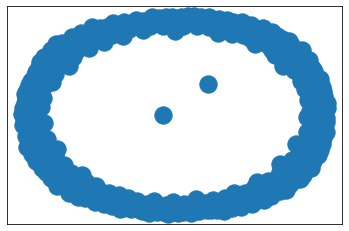

In [ ]:
network = nx.Graph()
network.add_nodes_from(examid)
nx.draw_networkx(network, with_labels=False)

## Addition of Graph Edges

This is the final network graph for the Glasgow dataset.

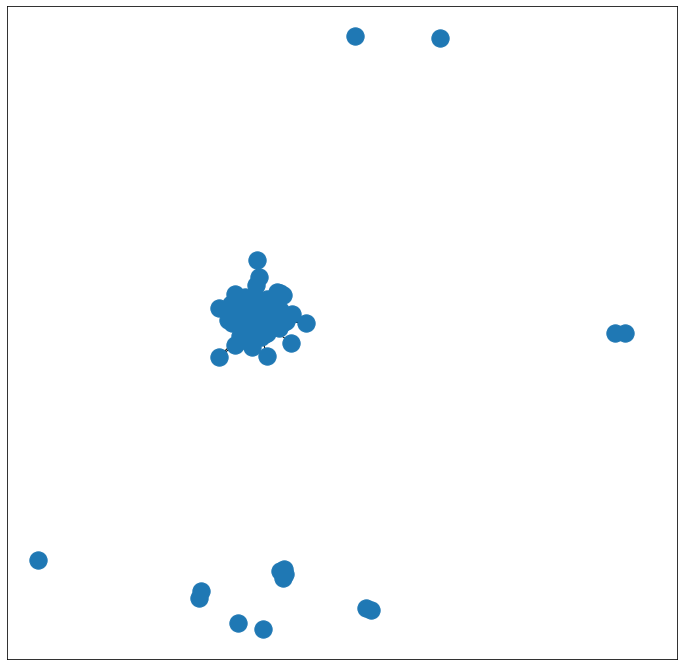

In [ ]:
for sublist in overlaps:
   for pair in itertools.combinations(sublist, 2):
      network.add_edge(pair[0], pair[1])
fig = plt.figure(figsize=(12,12))
nx.draw_networkx(network, with_labels=False)   

## Graph Statistics

In [ ]:
total_nodes = len(list(network.nodes))
actual_edges = len(network.edges)
possible_edges = (total_nodes*(total_nodes-1))/2
degree = max(dict(network.degree).values())
print("Total Nodes: ", total_nodes)
print("Actual Edges: ", actual_edges)
print("Possible Edges: ", possible_edges)
print("Percentage of Network Connected by Edges: ", actual_edges*100/possible_edges)
print("Highest Degree: ", degree)

Total Nodes:  419
Actual Edges:  19519
Possible Edges:  87571.0
Percentage of Network Connected by Edges:  22.28934236219753
Highest Degree:  283


## Graph Colouring (Equitable Colouring)

Assigns timeslots to exams.

In [ ]:
colors = equitable_color(network, len(allslots))
print(colors)

{'MATHS1017_1 - Mathematics 1': 0, 'ECON1001_1 - Economics 1A': 1, 'STATS1002_1 - Statistics 1Y': 2, 'LAW5015_1 - Corporate Governance': 3, 'LAW5197_1 - Corporate Finance': 4, 'LAW5042_1 - International Financial Reg': 5, 'COMPSCI1016_1 - Computing Science _ 1CT': 6, 'ASTRO1003_1 - Exploring the Cosmos 1X': 7, 'ECON5012_1 - Financial Services': 8, 'MGT5182_1 - Intl Strategic Mgmt': 9, 'ENG4179_1 - Thermal Engineering 4': 10, 'ENG5096_1 - Advanced Manufacture': 11, 'ENG5053_1 - Mech of Solids & Structures': 12, 'MGT5263_1 - Entrepreneurial Fin for SMEs': 13, 'COMPSCI5100_1 - Machine Learning & AI for DS': 14, 'ENG5062_1 - Navigation Systems M': 15, 'ENG5022_1 - Control M': 16, 'ENG5292_1 - Power Electronics and Drives M': 17, 'MED4042_1 - Immunology (intercal)': 18, 'MED4039_1 - Core Course (intercal)': 19, 'DENT3021_1 - Dental Stats (intercal)': 20, 'CHEM1001_1 - Chemistry 1': 21, 'BIOL1001_1 - Biology 1A': 22, 'ENG5302_1 - Ultrasound Technology and Apps': 23, 'ENG5049_1 - Lasers': 24,

In [ ]:
for k,v in colors.items():

  if(allslots.loc[v, "Exam 1"] == None):
    allslots.loc[v, "Exam 1"] = k
    allslots.loc[v, "Used Hours"] += getduration(k)
    allslots.loc[v, "Used Capacity"] += getstudentcount(k)
    allslots.loc[v, "Scheduled Exams"] += 1

  elif(allslots.loc[v, "Exam 2"] == None):
    allslots.loc[v, "Exam 2"] = k
    allslots.loc[v, "Used Hours"] += getduration(k)
    allslots.loc[v, "Used Capacity"] += getstudentcount(k)
    allslots.loc[v, "Scheduled Exams"] += 1   

  elif(allslots.loc[v, "Exam 3"] == None):
    allslots.loc[v, "Exam 3"] = k
    allslots.loc[v, "Used Hours"] += getduration(k)     
    allslots.loc[v, "Used Capacity"] += getstudentcount(k)
    allslots.loc[v, "Scheduled Exams"] += 1   

## Initial Solution

This is the final output of the Construction phase and the initial solution which will be optimised using Simulated Annealing.

In [ ]:
allslots.head()

,Room,Slot,Total Capacity,Total Hours,Used Capacity,Used Hours,Exam 1,Exam 2,Exam 3,Scheduled Exams
0,Kelvin Hall,8th Dec Morning,500,3,663,1.5,MATHS1017_1 - Mathematics 1,None,None,1
1,Kelvin Hall,8th Dec Afternoon,500,3,529,2.0,ECON1001_1 - Economics 1A,None,None,1
2,Kelvin Hall,8th Dec Evening,500,3,245,2.0,STATS1002_1 - Statistics 1Y,None,None,1
3,Kelvin Hall,9th Dec Morning,500,3,164,2.0,LAW5015_1 - Corporate Governance,None,None,1
4,Kelvin Hall,9th Dec Afternoon,500,3,77,2.0,LAW5197_1 - Corporate Finance,None,None,1


In [ ]:
print("Used Hours: ", allslots["Used Hours"].sum())
print("Total Hours: ", allslots["Total Hours"].sum())
print("Hour Deficit: ", allslots["Used Hours"].sum() - allslots["Total Hours"].sum())

Used Hours:  696.25
Total Hours:  3042
Hour Deficit:  -2345.75


These are exams that have clashes.

In [ ]:
allslots[(allslots["Total Capacity"]*allslots["Scheduled Exams"]<allslots["Used Capacity"]) | (allslots["Total Hours"]<allslots["Used Hours"])]

,Room,Slot,Total Capacity,Total Hours,Used Capacity,Used Hours,Exam 1,Exam 2,Exam 3,Scheduled Exams
0,Kelvin Hall,8th Dec Morning,500,3,663,1.5,MATHS1017_1 - Mathematics 1,None,None,1
1,Kelvin Hall,8th Dec Afternoon,500,3,529,2.0,ECON1001_1 - Economics 1A,None,None,1
21,Kelvin Hall,16th Dec Afternoon,500,3,571,2.0,CHEM1001_1 - Chemistry 1,None,None,1
22,Kelvin Hall,16th Dec Evening,500,3,754,1.5,BIOL1001_1 - Biology 1A,None,None,1
26,Bute,8th Dec Morning,230,3,301,2.0,ECON5002_1 - Basic Econometrics,None,None,1
...,...,...,...,...,...,...,...,...,...,...
298,WILT 114 (No longer suitable for exams,13th Dec Afternoon,50,3,94,2.0,ENGLANG2004_1 - English Language&Linguistc 2A,None,None,1
307,WILT 114 (No longer suitable for exams,16th Dec Afternoon,50,3,294,2.0,ACCFIN5017_1 - Int Capital Markets,None,None,1
334,OTC,16th Dec Evening,110,3,193,2.0,ECON5020_1 - Mathematical Finance,None,None,1
357,Gilmore Hill Theatre,15th Dec Evening,115,3,158,1.5,ACCFIN5219_1 - Corporate Finance & Valuation,None,None,1


# Optimisation Phase

The Optimisation phase uses Simulated Annealing to reach the global optimum by swapping exams.

In [ ]:
"""
#EXAM-ROOM MOVE

seen_list = []
for k in conflict_list:



  #k = np.random.choice(examid)
  #print(k)
  index_initial = allslots.loc[(allslots['Exam 1'] == k) | (allslots['Exam 2'] == k) | (allslots['Exam 3'] == k)].index.item()

  if(k not in seen_list):
    if(((allslots.loc[index_initial, "Total Capacity"] * allslots.loc[index_initial, "Scheduled Exams"]) < allslots.loc[index_initial, "Used Capacity"]) | (allslots.loc[index_initial, "Total Hours"] < allslots.loc[index_initial, "Used Hours"])):
      print("conflict")
    else:
      #do not remove exam
      print("no conflict")  
      seen_list.append(k)         
      continue


  for i in range (0, 100):
    index = allslots[(allslots["Total Capacity"]*allslots["Scheduled Exams"]>allslots["Used Capacity"]) & (allslots["Total Hours"]>allslots["Used Hours"])].sample(n=1).index.item()

    if(((allslots.loc[index, "Total Capacity"] * allslots.loc[index, "Scheduled Exams"]) > allslots.loc[index, "Used Capacity"]) & (allslots.loc[index, "Total Hours"] > allslots.loc[index, "Used Hours"])):
      print("available")
      if((network.has_edge(allslots.loc[index, "Exam 1"], k)) | (network.has_edge(allslots.loc[index, "Exam 2"], k)) | (network.has_edge(allslots.loc[index, "Exam 3"], k))):
        print("try new timeroom slot")
      elif((allslots.loc[index, "Used Hours"] + getduration(k) <  allslots.loc[index, "Total Hours"]) & (allslots.loc[index, "Used Capacity"] + getstudentcount(k) <  ( allslots.loc[index, "Scheduled Exams"] * allslots.loc[index, "Total Capacity"]))):
        add_exam(k, index)
        remove_exam(k, index_initial)       
        seen_list.append(k)          
        print("add exam")
        break
"""


'\n#EXAM-ROOM MOVE\n\nseen_list = []\nfor k in conflict_list:\n\n\n\n  #k = np.random.choice(examid)\n  #print(k)\n  index_initial = allslots.loc[(allslots[\'Exam 1\'] == k) | (allslots[\'Exam 2\'] == k) | (allslots[\'Exam 3\'] == k)].index.item()\n\n  if(k not in seen_list):\n    if(((allslots.loc[index_initial, "Total Capacity"] * allslots.loc[index_initial, "Scheduled Exams"]) < allslots.loc[index_initial, "Used Capacity"]) | (allslots.loc[index_initial, "Total Hours"] < allslots.loc[index_initial, "Used Hours"])):\n      print("conflict")\n    else:\n      #do not remove exam\n      print("no conflict")  \n      seen_list.append(k)         \n      continue\n\n\n  for i in range (0, 100):\n    index = allslots[(allslots["Total Capacity"]*allslots["Scheduled Exams"]>allslots["Used Capacity"]) & (allslots["Total Hours"]>allslots["Used Hours"])].sample(n=1).index.item()\n\n    if(((allslots.loc[index, "Total Capacity"] * allslots.loc[index, "Scheduled Exams"]) > allslots.loc[index, "Us

## Simulated Annealing Algorithm

In [ ]:
#EXAM-EXAM SWAP
temp = 1000
temps = []


for k in range(0,10000):

  cf1 = costfunction(allslots)

  e1 = np.random.choice(examid)
  e2 = np.random.choice(examid)  

  swap_exams(e1,e2)
  cf2 = costfunction(allslots)
  
  diff = cf2 - cf1
  t = temp / float(k + 1)
  temps.append(t)
  metropolis = np.exp(-diff / t)

  print(t)

  #if(cf2>=cf1):
    #swap_exams(e1,e2)

  if(diff >= 0 or np.random.rand() > metropolis):
    swap_exams(e1,e2)      

Streaming output truncated to the last 5000 lines.
0.19996000799840033
0.19992003198720512
0.19988007195682592
0.19984012789768185
0.1998001998001998
0.1997602876548142
0.19972039145196724
0.19968051118210864
0.19964064683569574
0.1996007984031936
0.19956096587507482
0.19952114924181963
0.19948134849391583
0.1994415636218588
0.19940179461615154
0.19936204146730463
0.19932230416583616
0.1992825827022718
0.19924287706714486
0.199203187250996
0.19916351324437362
0.19912385503783353
0.1990842126219391
0.19904458598726116
0.19900497512437812
0.19896538002387584
0.1989258006763477
0.19888623707239458
0.19884668920262477
0.1988071570576541
0.19876764062810576
0.1987281399046105
0.1986886548778065
0.1986491855383393
0.19860973187686196
0.19857029388403494
0.1985308715505261
0.19849146486701072
0.19845207382417146
0.1984126984126984
0.19837333862328904
0.19833399444664815
0.198294665873488
0.19825535289452814
0.19821605550049554
0.19817677368212447
0.19813750743015654
0.19809825673534073
0.1980

## Temperature Schedule

Text(0.5, 1.0, 'Temperature Schedule for SA')

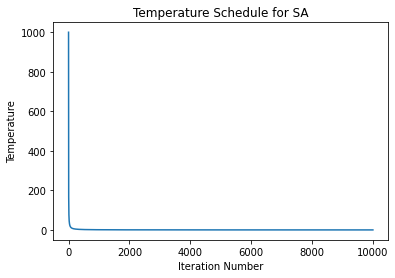

In [ ]:
plt.plot(temps)
plt.xlabel("Iteration Number")
plt.ylabel("Temperature")
plt.title("Temperature Schedule for SA")

# Final Solution

This is the final output of the system. Resolved.csv contains the timetable generated after the execution of both phases.

In [ ]:
allslots.to_csv("resolved.csv")

In [ ]:
allslots

,Room,Slot,Total Capacity,Total Hours,Used Capacity,Used Hours,Exam 1,Exam 2,Exam 3,Scheduled Exams
0,Kelvin Hall,8th Dec Morning,500,3,663,1.5,MATHS1017_1 - Mathematics 1,None,None,1
1,Kelvin Hall,8th Dec Afternoon,500,3,529,2.0,ECON1001_1 - Economics 1A,None,None,1
2,Kelvin Hall,8th Dec Evening,500,3,245,2.0,STATS1002_1 - Statistics 1Y,None,None,1
3,Kelvin Hall,9th Dec Morning,500,3,164,2.0,LAW5015_1 - Corporate Governance,None,None,1
4,Kelvin Hall,9th Dec Afternoon,500,3,389,2.0,BIOL2040_1 - Cntemprary Issues in Biol 2Y,None,None,1
...,...,...,...,...,...,...,...,...,...,...
1009,Wellington Library,16th Dec Afternoon,25,3,0,0.0,None,None,None,0
1010,Wellington Library,16th Dec Evening,25,3,0,0.0,None,None,None,0
1011,Wellington Library,17th Dec Morning,25,3,0,0.0,None,None,None,0
1012,Wellington Library,17th Dec Afternoon,25,3,0,0.0,None,None,None,0


These are exams that still have clashes due to capacity violations.

In [ ]:
allslots[(allslots["Total Capacity"]*allslots["Scheduled Exams"]<allslots["Used Capacity"]) | (allslots["Total Hours"]<allslots["Used Hours"])]

,Room,Slot,Total Capacity,Total Hours,Used Capacity,Used Hours,Exam 1,Exam 2,Exam 3,Scheduled Exams
0,Kelvin Hall,8th Dec Morning,500,3,663,1.5,MATHS1017_1 - Mathematics 1,None,None,1
1,Kelvin Hall,8th Dec Afternoon,500,3,529,2.0,ECON1001_1 - Economics 1A,None,None,1
21,Kelvin Hall,16th Dec Afternoon,500,3,571,2.0,CHEM1001_1 - Chemistry 1,None,None,1
22,Kelvin Hall,16th Dec Evening,500,3,754,1.5,BIOL1001_1 - Biology 1A,None,None,1
34,Bute,10th Dec Evening,230,3,332,1.0,MED2006_1 - MBChB 2 Written Paper 1,None,None,1
38,Bute,13th Dec Afternoon,230,3,411,2.0,POLITIC2001_1 - Politics 2A: Hist of Pol Thght,None,None,1
41,Bute,14th Dec Afternoon,230,3,444,1.5,MATHS2004_1 - Maths 2B,None,None,1
50,Bute,17th Dec Afternoon,230,3,592,2.0,BIOL2039_1 - Fundamental Topics in Biol 2X,None,None,1
51,Bute,17th Dec Evening,230,3,325,1.0,MED1005_1 - MBChB 1 Written Paper 1,None,None,1
52,Randolph,8th Dec Morning,85,3,404,2.0,ECON1012_1 - Introductory Maths for Econ,None,None,1


These are exams without any clashes.

In [ ]:
allslots[(allslots["Total Capacity"]*allslots["Scheduled Exams"]>=allslots["Used Capacity"]) & (allslots["Total Hours"]>=allslots["Used Hours"])]

,Room,Slot,Total Capacity,Total Hours,Used Capacity,Used Hours,Exam 1,Exam 2,Exam 3,Scheduled Exams
2,Kelvin Hall,8th Dec Evening,500,3,245,2.0,STATS1002_1 - Statistics 1Y,None,None,1
3,Kelvin Hall,9th Dec Morning,500,3,164,2.0,LAW5015_1 - Corporate Governance,None,None,1
4,Kelvin Hall,9th Dec Afternoon,500,3,389,2.0,BIOL2040_1 - Cntemprary Issues in Biol 2Y,None,None,1
5,Kelvin Hall,9th Dec Evening,500,3,241,2.0,ENG3037_1 - Mechanics of Solids 3,None,None,1
6,Kelvin Hall,10th Dec Morning,500,3,156,2.0,COMPSCI1016_1 - Computing Science _ 1CT,None,None,1
...,...,...,...,...,...,...,...,...,...,...
1009,Wellington Library,16th Dec Afternoon,25,3,0,0.0,None,None,None,0
1010,Wellington Library,16th Dec Evening,25,3,0,0.0,None,None,None,0
1011,Wellington Library,17th Dec Morning,25,3,0,0.0,None,None,None,0
1012,Wellington Library,17th Dec Afternoon,25,3,0,0.0,None,None,None,0
